In [1]:
! pip install pydicom nibabel pyradiomics

     |████████████████████████████████| 7.0MB 3.2MB/s 
     |████████████████████████████████| 163kB 42.4MB/s 
     |████████████████████████████████| 4.4MB 37.0MB/s 
     |████████████████████████████████| 40kB 25.2MB/s 
     |████████████████████████████████| 42.5MB 1.4MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: PyWavelets 1.0.3
    Uninstalling PyWavelets-1.0.3:
      Successfully uninstalled PyWavelets-1.0.3


In [0]:
from __future__ import print_function
import os, sys
import logging
import six, csv
import numpy as np
import pandas as pd
import glob
import tqdm

# import matplotlib
# matplotlib.use("AGG")
import matplotlib.pyplot as plt

import pydicom as dicom
import nibabel as nib
import skimage
import SimpleITK as sitk

import radiomics
from radiomics import featureextractor
from radiomics import firstorder, glcm, imageoperations, shape, glrlm, glszm

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
cd "/content/gdrive/My Drive/projects/ClinicAI/FinalProject/"

/content/gdrive/My Drive/projects/ClinicAI/FinalProject


In [5]:
ls

 ALL_epoch_100_train_loss_3Dense.png   train-images/
 ALL_epoch_100_train_loss_Dense3.png   train_loss.png
 ALL_epoch_100_train_loss.png          train-survival.csv
 ALL_epoch_100_train_loss_test.png     vgg_gru.csv
 data/                                 vgg_gru.ipynb
 epoch_30_train_loss.png               vgg_lstm.ipynb
 epoch_55_train_loss.png               vgg_rad_age_3Dense.csv
 epoch_60_train_loss.png               vgg_rad_age_3Dense.h5
 features/                             vgg_rad_age.csv
 feature_selection.ipynb               vgg_rad_age_Dense3.csv
 generate_X_image_npz.ipynb            vgg_rad_age_train38.csv
 log/                                  vgg_X_3_40slice.h5
'model parameters.gdoc'                vgg_X_3_40slice.npy
 predict_class.ipynb                   X_3_40slice.npz
 radiomics_feature_extraction.ipynb    X_3.npz
 radiomics_featureName.npy             X_3_vgg.csv
 rf_age.csv                            X_3_vgg_epoch30.csv
 rf.csv                                X_3_vg

In [0]:
def load_nii_gz(label_fpath, transpose=False):
    data = nib.load(label_fpath)
    pixel_array = data.get_fdata()
    if transpose:
        pixel_array = np.transpose(pixel_array, axes=(2,1,0))
    return pixel_array 

In [0]:
X = np.load("X_train.npz")
y = np.load("y_survival.npy")

In [8]:
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, Input, GRU, Bidirectional, GlobalAveragePooling1D, Concatenate
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras.optimizers import Adam, SGD, RMSprop
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.utils import to_categorical

Using TensorFlow backend.


In [0]:
vgg = VGG16(weights='imagenet', include_top=False)

W0620 05:13:34.104287 139761239959424 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0620 05:13:34.126425 139761239959424 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0620 05:13:34.129357 139761239959424 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0620 05:13:34.155136 139761239959424 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0620 05:13:34.695857 139761239959424 deprecation_wrapp

In [0]:
# X_3 = np.zeros((39, 155, 240, 240, 3))
# for i in range(39):
#     X_3[i, :, :, :, 0] = X["t1"][i]
#     X_3[i, :, :, :, 1] = X["t1ce"][i]
#     X_3[i, :, :, :, 2] = X["flair"][i]
# #     

# np.savez_compressed("X_3", rgb=X_3)

# X_3 = np.load("X_3.npz")["rgb"][:, 58:98, ...]
X_3_40 = np.load("X_3_40slice.npz")["rgb"]

In [0]:
np.sum(X["seg"][:, :, ...])

6586778

In [0]:
np.sum(X["seg"][:, 58:98, ...])

4008045

In [0]:
X_3_40.shape

(39, 40, 240, 240, 3)

In [0]:
# np.savez_compressed("X_3_40slice", rgb=X_3)

In [0]:
# t1_t1ce_flair_vgg = []
# for x in tqdm.tqdm(X_3_40):
#     x = skimage.transform.resize(x, (40,224,224))
# #     x = skimage.color.gray2rgb(x) 
  
#     t1_t1ce_flair_vgg.append(vgg.predict(x).reshape(40,-1))
# t1_t1ce_flair_vgg = np.array(t1_t1ce_flair_vgg)


100%|██████████| 39/39 [00:57<00:00,  1.48s/it]


In [0]:
# t1_t1ce_flair_vgg.shape

(39, 40, 25088)

In [0]:
# np.save("vgg_X_3_40slice", t1_t1ce_flair_vgg)
t1_t1ce_flair_vgg = np.load("vgg_X_3_40slice.npy")

In [10]:
X_radiomics = np.load("X_radiomicsFeatures.npz")
radiomicsFeatures = []
for i in X_radiomics.items():
#     print(i[0])
    if i[0]!="featureName":
        radiomicsFeatures.append(i[1])
X_radFeatures = np.concatenate(radiomicsFeatures[:], axis=1)
X_radFeatures.shape

(39, 13560)

In [0]:
from joblib import dump, load
sfm3 = load("select_rf_5e_3.joblib")

In [12]:
X_radSel = sfm3.transform(X_radFeatures)
X_radSel.shape

(39, 12)

In [0]:
X_vgg_rad_age = np.concatenate((t1_t1ce_flair_vgg.reshape(39,-1), X_radSel,X["age"].reshape(-1,1)), axis = 1)

In [14]:
X_vgg_rad_age.shape

(39, 1003533)

In [0]:
def dnn():
#     inputs = Input(shape=(1003533,))
    vgg = Input(shape=(40*25088, ))
    rad = Input(shape=(12, ))
    age = Input(shape=(1, ))
    
    x1 = Dense(32, kernel_initializer='normal', activation='relu')(vgg)
    x1 = Dense(32, kernel_initializer='normal', activation='relu')(x1)
    x1 = Dense(32, kernel_initializer='normal', activation='relu')(x1)
    
    x2 = Dense(8, kernel_initializer='normal', activation='relu')(rad)
    x2 = Dense(8, kernel_initializer='normal', activation='relu')(x2)
    x2 = Dense(8, kernel_initializer='normal', activation='relu')(x2)
    
#     x = Dense(16, kernel_initializer='normal', activation='relu')(inputs)
    
    concat = Concatenate()([x1, x2, age])
    
    outputs = Dense(1, kernel_initializer='normal')(concat)
    model = Model(inputs=[vgg, rad, age], outputs=outputs)
    
    model.compile(loss='mse', optimizer='adam')
    return model


In [49]:
model = dnn()
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 1003520)      0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 12)           0                                            
__________________________________________________________________________________________________
dense_21 (Dense)                (None, 32)           32112672    input_7[0][0]                    
__________________________________________________________________________________________________
dense_24 (Dense)                (None, 8)            104         input_8[0][0]                    
__________________________________________________________________________________________________
dense_22 (

In [50]:
history = model.fit([t1_t1ce_flair_vgg.reshape(39,-1), X_radSel, X["age"]], y, validation_split=0.25,  epochs=100)

Train on 29 samples, validate on 10 samples
Epoch 1/100
29/29 [==============================] - 1s 50ms/step - loss: 386861.0312 - val_loss: 446768.3125
Epoch 2/100
29/29 [==============================] - 0s 5ms/step - loss: 373120.3750 - val_loss: 392241.3750
Epoch 3/100
29/29 [==============================] - 0s 5ms/step - loss: 332040.2188 - val_loss: 333363.4375
Epoch 4/100
29/29 [==============================] - 0s 5ms/step - loss: 288900.8125 - val_loss: 267996.6562
Epoch 5/100
29/29 [==============================] - 0s 5ms/step - loss: 241790.1875 - val_loss: 205843.8281
Epoch 6/100
29/29 [==============================] - 0s 4ms/step - loss: 198025.2656 - val_loss: 152788.3125
Epoch 7/100
29/29 [==============================] - 0s 4ms/step - loss: 162423.0000 - val_loss: 126709.4531
Epoch 8/100
29/29 [==============================] - 0s 4ms/step - loss: 148540.0000 - val_loss: 139652.4375
Epoch 9/100
29/29 [==============================] - 0s 4ms/step - loss: 163614.343

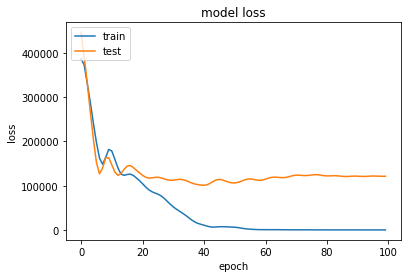

In [51]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('ALL_epoch_100_train_loss_3Dense.png')

In [0]:
model.save("vgg_rad_age_3Dense.h5")

In [0]:
# t1_vgg = []
# for x in tqdm.tqdm(X["t1"]):
#     x = skimage.transform.resize(x, (155,224,224))
#     x = skimage.color.gray2rgb(x) 
#     t1_vgg.append(vgg.predict(x).reshape(155,-1))
# t1_vgg = np.array(t1_vgg)

In [0]:
# t1ce_vgg = []
# for x in tqdm.tqdm(X["t1ce"]):
#     x = skimage.transform.resize(x, (155,224,224))
#     x = skimage.color.gray2rgb(x) 
#     t1ce_vgg.append(vgg.predict(x).reshape(155,-1))
# t1ce_vgg = np.array(t1ce_vgg)

In [0]:
# t2_vgg = []
# for x in tqdm.tqdm(X["t2"]):
#     x = skimage.transform.resize(x, (155,224,224))
#     x = skimage.color.gray2rgb(x) 
#     t2_vgg.append(vgg.predict(x).reshape(155,-1))
# t2_vgg = np.array(t2_vgg)

In [0]:
# np.savez_compressed("X_vgg.npz", t1=t1_vgg, t1ce=t1ce_vgg, t2=t2_vgg, flair=flair_vgg)

In [0]:
# X_vgg = np.load("X_vgg.npz")

In [0]:
from keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, \
                             verbose=2, mode='auto', baseline=None, restore_best_weights=False)

In [0]:
test_image_folder = "./test-images/image/"

sample_submission = np.genfromtxt('./sample_submission.csv', 
                                  delimiter=',', 
                                  dtype='str',
                                  skip_header = 1)
test_encode_list = sample_submission[:, 0]

In [0]:
X_test=np.load("X_test.npz")

In [42]:
X_test["t1"][0][58:98].shape

(40, 240, 240)

In [0]:
# X_test_3 = np.zeros((20,40,240,240,3))
# for i in range(20):
#     X_test_3[i, :, :, :, 0] = X_test["t1"][i][58:98]
#     X_test_3[i, :, :, :, 1] = X_test["t1ce"][i][58:98]
#     X_test_3[i, :, :, :, 2] = X_test["flair"][i][58:98]


In [0]:
# np.save("X_test_3_vgg_40slice", X_test_3)

In [0]:
# X_test_vgg = []
# for x in tqdm.tqdm(X_test_3):
#     x = skimage.transform.resize(x, (40,224,224))
# #     x = skimage.color.gray2rgb(x) 
  
#     X_test_vgg.append(vgg.predict(x).reshape(40,-1))
# X_test_vgg = np.array(X_test_vgg)


100%|██████████| 20/20 [00:29<00:00,  1.47s/it]


In [43]:
X_test_vgg = np.load("X_test_3_vgg_40slice.npy")
X_test_vgg.shape

(20, 40, 25088)

In [44]:
X_test_radiomics = np.load("X_test_radiomicsFeatures.npz")
radiomicsFeatures2 = []
for i in X_test_radiomics.items():
#     print(i[0])
    if i[0]!="featureName":
        radiomicsFeatures2.append(i[1])
X_test_radFeatures = np.concatenate(radiomicsFeatures2[:], axis=1)
X_test_radFeatures.shape

(20, 13560)

In [45]:
X_test_radSel = sfm3.transform(X_test_radFeatures)
X_test_radSel.shape

(20, 12)

In [46]:
X_test_vgg_rad_age = np.concatenate((X_test_vgg.reshape(20, -1), X_test_radSel, X_test["age"].reshape(-1,1)), axis = 1)
X_test_vgg_rad_age.shape

(20, 1003533)

In [0]:
# test_X_flair = np.zeros((len(test_encode_list), 155, 240, 240))

# for i, encode in enumerate(test_encode_list):
#     test_X_flair[i, :, :, :] = load_nii_gz(os.path.join(test_image_folder, encode, 'flair.nii.gz'), transpose=True)

In [0]:
# test_flair = []
# for x in test_X_flair:
#     x = skimage.transform.resize(x, (155,224,224))
#     x = skimage.color.gray2rgb(x) 
#     test_flair.append(vgg.predict(x).reshape(155,-1))
# test_X_flair = np.array(test_flair)

In [0]:
# test_preds = model.predict(X_test_vgg_rad_age)
test_preds = model.predict([X_test_vgg.reshape(20, -1), X_test_radSel, X_test["age"]])

In [54]:
test_preds

array([[376.6465 ],
       [352.9852 ],
       [356.65985],
       [270.4827 ],
       [405.02255],
       [400.39194],
       [507.87766],
       [460.4667 ],
       [341.924  ],
       [531.9094 ],
       [471.20593],
       [521.0797 ],
       [402.20047],
       [270.40582],
       [351.62265],
       [334.91525],
       [467.0105 ],
       [638.10803],
       [526.0171 ],
       [683.8479 ]], dtype=float32)

In [55]:
solution_path = './vgg_rad_age_3Dense.csv'
with open(solution_path, 'w') as f:
    f.write('Encode,Survival\n')
    for i, encode in enumerate(test_encode_list):
        print(encode, test_preds[i][0]) 
        f.write(encode + ',' + str(test_preds[i][0]) + '\n')

4zqmljfrc675dtrky3gchyx87jkl3czk 376.6465
t6if2ohjnd7mh06z81wwd3sp86h427ad 352.9852
7rmkmfclt0mkmqs5b3e6rny5hwgwo11y 356.65985
chjxxykw2lz1v37hgriyniblgi41d5y3 270.4827
orhcxlyoc0x6idbzlqmbsdqduehdy75o 405.02255
7rxxiwwbbxy0yoatpsyltln3v2wtne9e 400.39194
0r3e6ezursuo5y6m3jwpztq763cjki0p 507.87766
haz4ax59boce4twwwpzfq7hwydgqn9we 460.4667
zcn7u2kqbrqlzgf07yzzjg5mqyqgqul1 341.924
27w6sraww3g2ui9fxpu08tcgyocprtqg 531.9094
sedxnmxte7gxrdbbpx8p8b3jhurlrx3n 471.20593
ji97woc3vcyn9lzq5xfpk3j95i5vswmm 521.0797
09amv752acxnzvkfughexk0wilhxdtd5 402.20047
gg4o6f2xyb2zpclttmjy35lqnasg9vz4 270.40582
hjhau2e5j5p1zpwbbuocjiwplq20l2dz 351.62265
2398n5c5yz5km503of24gbxdb803gq5q 334.91525
do2ausaft9rrqogh8y16qb0vuy5roywm 467.0105
tspn2x2dggh1ugi1vizmvcrsll644p2a 638.10803
djquj44l7imhygd741v81p9gfc4nu5xk 526.0171
jbhvvv6rpu7mbs5bpu1byb31c9yzo9db 683.8479
